In [1]:
import random
from dataclasses import dataclass
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import smooth

In [2]:
@dataclass
class ETSParams:
    trend: Literal["A", "Ad", "M", "Md", "N"]
    season: Literal["A", "M", "N"]
    error: Literal["A", "M"]

    alpha: float
    beta: float
    gamma: float
    phi: float

    l: float
    b: float
    s: np.ndarray

    t: int = 1

    @classmethod
    def random_init(
        cls,
        error: Literal["A", "M"],
        trend: Literal["A", "Ad", "M", "Md", "N"],
        season: Literal["A", "M", "N"],
        seed: Optional[int] = None,
    ) -> "ETSParams":
        if seed:
            np.random.seed(seed)

        alpha = np.random.uniform(0, 1)
        beta = np.random.uniform(0, alpha)
        gamma = np.random.uniform(0, 1 - alpha)
        phi = np.random.uniform(0, 1)

        l = np.random.normal(0, 1)
        b = np.random.normal(0, 1) if trend != "N" else 0
        s = np.random.normal(0, 1, 12) if season != "N" else np.zeros(12)

        return ETSParams(trend, season, error, alpha, beta, gamma, phi, l, b, s)


ets_params = ETSParams.random_init("A", "A", "A", seed=42)

In [3]:
def update_additive_ets(params: ETSParams, eps: Optional[float] = None):
    l = params.l
    b = params.b
    s = params.s

    alpha = params.alpha
    beta = params.beta
    phi = params.phi
    gamma = params.gamma

    eps = eps or 10 * random.gauss(0, 1)
    if params.season != "M":
        new_s = s.copy()

        if params.season == "A":
            new_s[params.t % 12] += gamma * eps
        elif params.season == "N":
            new_s *= 0

        if params.trend == "N":
            new_l = l + alpha * eps
            new_b = 0

            y = new_l + new_s[params.t % 12] + eps
        elif params.trend == "A":
            new_l = l + b + alpha * eps
            new_b = b + beta * eps

            y = new_l + new_b + new_s[params.t % 12] + eps
        elif params.trend == "Ad":
            new_l = l + phi * b + alpha * eps
            new_b = b + phi * beta + beta * eps

            y = new_l + phi * new_b + new_s[params.t % 12] + eps
        elif params.trend == "M":
            new_l = l * b + alpha * eps
            new_b = b + beta * eps / l

            y = new_l * new_b + new_s[params.t % 12] + eps
        elif params.trend == "Md":
            new_l = l * b**phi + alpha * eps
            new_b = b**phi + beta * eps / l

            y = new_l * new_b**phi + new_s[params.t % 12] + eps
        else:
            raise ValueError(f"Unknown trend type: {params.trend}")
    else:
        if params.trend == "N":
            new_l = l + alpha * eps
            new_b = b
            new_s = s.copy()
            new_s[params.t % 12] += gamma * eps / l

            y = new_l * new_s[params.t % 12] + eps
        elif params.trend == "A":
            new_l = l + b + alpha * eps / s[params.t % 12]
            new_b = b + beta * (l + b) * eps
            new_s = s.copy()
            new_s[params.t % 12] += gamma * eps / (l + b)

            y = (new_l + new_b) * new_s[params.t % 12] + eps
        elif params.trend == "Ad":
            new_l = l + phi * b + alpha * eps / s[params.t % 12]
            new_b = phi * b + beta * (l + phi * b) * eps
            new_s = s.copy()
            new_s[params.t % 12] += gamma * eps / (l + phi * b)

            y = (new_l + phi * new_b) * new_s[params.t % 12] + eps
        elif params.trend == "M":
            new_l = l * b + alpha * eps / s[params.t % 12]
            new_b = b * (1 + beta * eps)
            new_s = s.copy()
            new_s[params.t % 12] += gamma * eps / (l * b)

            y = new_l * new_b * new_s[params.t % 12] + eps
        elif params.trend == "Md":
            new_l = l * b**phi + alpha * eps / s[params.t % 12]
            new_b = b**phi * (1 + beta * eps)
            new_s = s.copy()
            new_s[params.t % 12] += gamma * eps / (l * b)

            y = new_l * new_b**phi * new_s[params.t % 12] + eps
        else:
            raise ValueError(f"Unknown trend type: {params.trend}")

    return ETSParams(
        t=params.t + 1,
        trend=params.trend,
        season=params.season,
        error=params.error,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        phi=phi,
        l=new_l,
        b=new_b,
        s=new_s,
    ), y

In [4]:
def generate_ets(params: ETSParams):
    while True:
        params, y = update_additive_ets(params)
        yield y

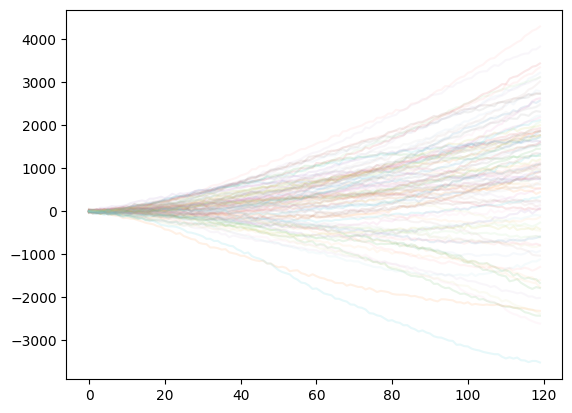

In [5]:
sensible_models = [
    {"error": "A", "trend": "N", "season": "N"},
    {"error": "A", "trend": "A", "season": "N"},
    {"error": "A", "trend": "Ad", "season": "N"},
    {"error": "A", "trend": "N", "season": "A"},
    {"error": "A", "trend": "A", "season": "A"},
    {"error": "A", "trend": "Ad", "season": "A"},
    {"error": "A", "trend": "N", "season": "M"},
    {"error": "A", "trend": "A", "season": "M"},
    {"error": "A", "trend": "Ad", "season": "M"},
    {"error": "M", "trend": "N", "season": "N"},
    {"error": "M", "trend": "A", "season": "N"},
    {"error": "M", "trend": "Ad", "season": "N"},
    {"error": "M", "trend": "N", "season": "A"},
    {"error": "M", "trend": "A", "season": "A"},
    {"error": "M", "trend": "Ad", "season": "A"},
    {"error": "M", "trend": "N", "season": "M"},
    {"error": "M", "trend": "A", "season": "M"},
    {"error": "M", "trend": "Ad", "season": "M"},
]

model = sensible_models[5]

params = ETSParams.random_init(**model, seed=42)

ts = []

fig, ax = plt.subplots()

cmap = plt.get_cmap("tab20")
for i in range(100):
    gen = generate_ets(params)
    ys = np.array([next(gen) for _ in range(120)])
    ts.append(ys)
    plt.plot(ys, color=cmap(i / 100), alpha=0.1, zorder=0.1)

In [6]:
"".join(model.values())

'AAdA'

In [7]:
adam = smooth.Adam("".join(model.values()), lags=[12])
adam.fit(pd.Series(ts[0]), h=12)

Initial value is not selected. Switching to optimal.


TypeError: slice indices must be integers or None or have an __index__ method